<a href="https://colab.research.google.com/github/CalculatedContent/WeightWatcher/blob/master/examples/WW-ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# WeightWatcher ResNet

https://calculationconsulting.com


### Analysis of pyTorch ResNet Models

ResNet, with the same number of layers,  is a much smaller model than VGG, with 20X less parameters.

This notebook only analyzes 5 ResNet models, although [the weightwatcher Nature paper](https://www.nature.com/articles/s41467-021-24025-8) does many more.

We will see the power law exponents $\alpha$ approach 2 (or less) and do not vary much between layers until the very end, where the power law model breaks down and the final layers are not wel fit by a Power Law (and probably undertrained)

Compare this to VGG, where $\alpha$ immediately increases with layer depth, and only $\hat{\alpha}$ is comparable between models.



For the VGG series, only the weighted alpha $\hat{\alpha}$  decreases with test error.

Here, the average layer PL exponent $\langle\alpha\rangle$ decreases with test error,   as expected although the correlation is not as good as $\hat{\alpha}$ 

Importantly, notice that the $\hat{\alpha}$ metric improves upon the log Spectral Norm metric by a small but noticible amount


In [2]:
!touch resnet18.png CV-models.png

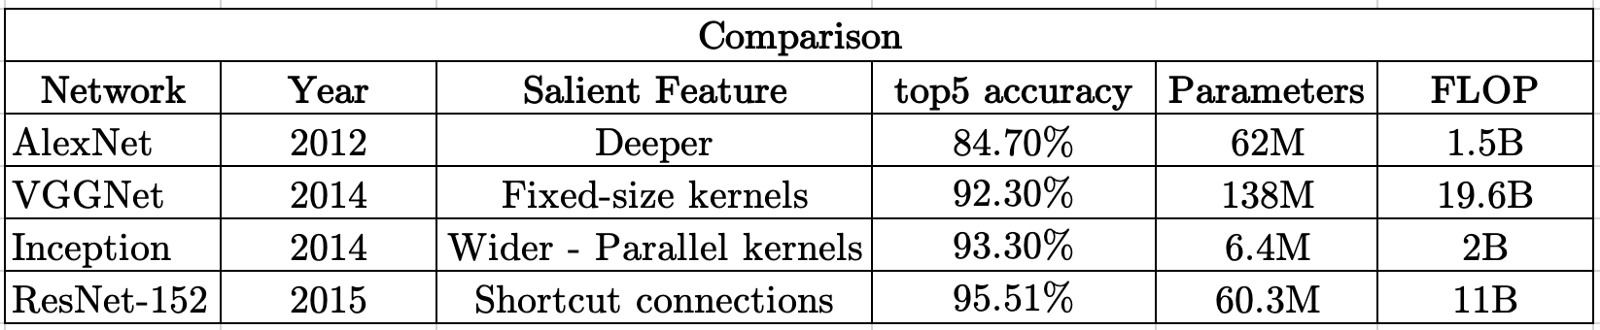

In [2]:
from IPython.display import Image
Image(filename='CV-models.png',width=800, height=400)

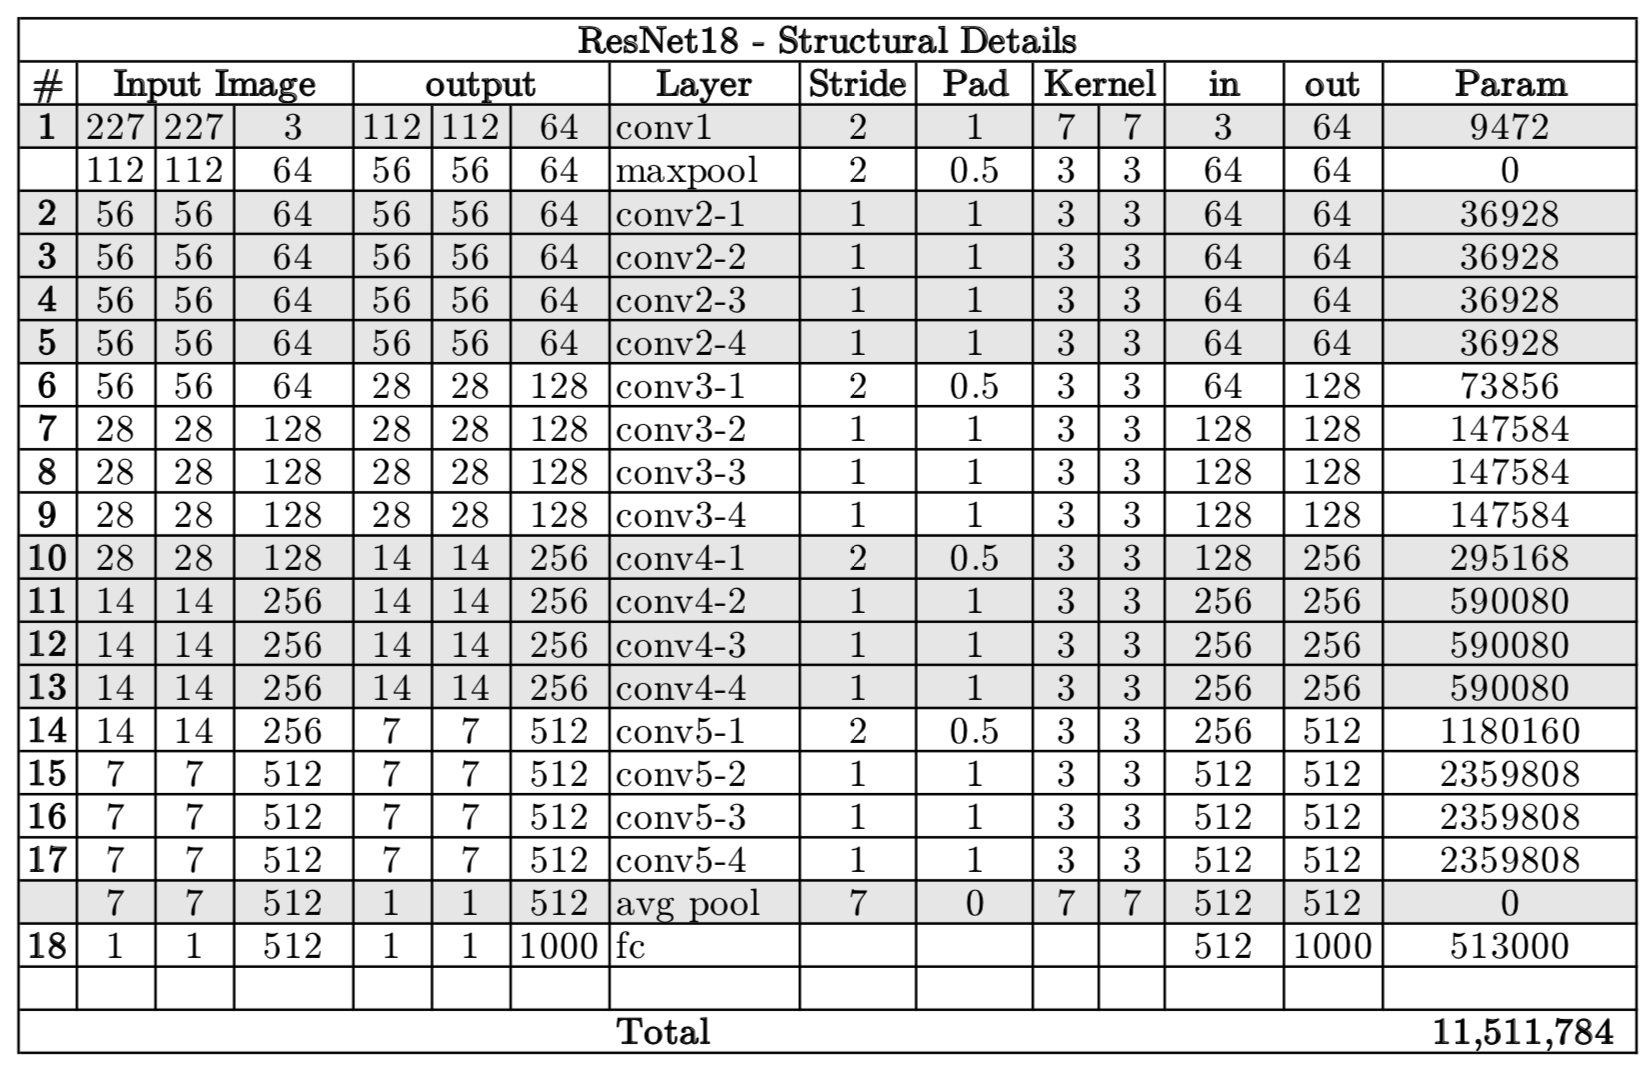

In [3]:
Image(filename='resnet18.png',width=800, height=400)

## Comparison of VGG and ResNet

https://towardsdatascience.com/an-overview-of-resnet-and-its-variants-5281e2f56035

### Key Idea:  Residual Connections

Improves gradient / information flow through the network

Because of this, there are much deeper ResNet variants.  In fact, some researchers have trained ResNet variants with 1001 layers!

## Results

In contrast to the VGG series, the ResNet Average Alpha $\langle\alpha\rangle$ is positively correlated with the Test Error:  smaller average alpha corresponds to better generalization.  Moreover, the layer $\alpha$ are fairly constant, and near $2.0$, for at least $3/4$ of the network

## Calculations of Results

In [4]:
# Suppress the powerlaw package warnings
# "powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide"
# "powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide"
import warnings
warnings.simplefilter(action='ignore', category=RuntimeWarning)

In [5]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn import metrics
import scipy.stats as stats

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

### Import WeightWatcher

set custom Logging at WARN Level

In [ ]:
import sys
if 'google.colab' in sys.modules:
    !pip install weightwatcher

In [6]:

import weightwatcher as ww
import torchvision.models as models

import logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(ww.__name__)
logger.setLevel(logging.INFO)

ww.__version__#,  torchvision.__version__

'0.6.5'

### Create all models now

In [7]:

series_name = 'ResNet'
all_names = [ 'resnet18', 'resnet34', 'resnet50', 'resnet101','resnet152']

colors = ['blue', 'green', 'teal', 'orange', 'red']


In [8]:


all_models = []
all_models.append(models.resnet18(pretrained=True))
all_models.append(models.resnet34(pretrained=True))
all_models.append(models.resnet50(pretrained=True))
all_models.append(models.resnet101(pretrained=True))
all_models.append(models.resnet152(pretrained=True))


### Get reported accuracies from pytorch website

https://pytorch.org/docs/stable/torchvision/models.html

<pre>
<table class="docutils align-default">
<colgroup>
<col style="width: 55%" />
<col style="width: 22%" />
<col style="width: 22%" />
</colgroup>
<thead>
<thead>
<tr class="row-odd"><th class="head"><p>Network</p></th>
<th class="head"><p>Top-1 error</p></th>
<th class="head"><p>Top-5 error</p></th>
</tr>
</thead>
<tbody>

<tr class="row-odd"><td><p>ResNet-18</p></td>
<td><p>30.24</p></td>
<td><p>10.92</p></td>
</tr>
<tr class="row-even"><td><p>ResNet-34</p></td>
<td><p>26.70</p></td>
<td><p>8.58</p></td>
</tr>
<tr class="row-odd"><td><p>ResNet-50</p></td>
<td><p>23.85</p></td>
<td><p>7.13</p></td>
</tr>
<tr class="row-even"><td><p>ResNet-101</p></td>
<td><p>22.63</p></td>
<td><p>6.44</p></td>
</tr>
<tr class="row-odd"><td><p>ResNet-152</p></td>
<td><p>21.69</p></td>
<td><p>5.94</p></td>
</tr>

</tbody>
</table>
</pre>

In [9]:
top1_errors= {
    
    "resnet18": 30.24,
    "resnet34": 26.70,
    "resnet50": 23.85,
    "resnet101": 22.63,
    "resnet152": 21.69 

}

In [10]:
top5_errors= {
    
    "resnet18": 10.92,
    "resnet34": 8.58,
    "resnet50": 7.13,
    "resnet101": 6.44,
    "resnet152": 5.94    

}

## Run WeightWatcher, collect summary and details (as dataframes) for all models

In [ ]:
#%%capture

import warnings
warnings.filterwarnings('ignore')

all_details = []
all_summaries = []
for im, name in enumerate(all_names):
    print(im, name)
    watcher = ww.WeightWatcher(model=all_models[im])
    details = watcher.analyze(ww2x=True, randomize=True, mp_fit=True, min_evals=50)
    summary =  watcher.get_summary()
    all_summaries.append(summary)
    all_details.append(details)

0 resnet18


In [ ]:
plt.rcParams.update({'font.size': 16})
from pylab import rcParams
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (7,7),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params)

### Test Accuracy vs WeightWatcher Shape and Scale Metrics

In [ ]:
def plot_test_accuracy(metric, xlabel, title, series_name, \
                       all_names, all_summaries, top_errors, save=False):
    """Create plot of Metric vs Reported Test Accuracy, and run Linear Regression"""
    
    num = len(all_names)
    xs, ys = np.empty(num), np.empty(num)
    for im, modelname in enumerate(all_names):    

        summary = all_summaries[im]
        x = summary[metric]
        xs[im] = x

        error = top_errors[modelname]
        y = 100.0-error
        ys[im] = y

        label = modelname
        plt.scatter(x, y, label=label)


    xs = xs.reshape(-1,1)
    ys = ys.reshape(-1,1)
    regr = LinearRegression()
    regr.fit(xs, ys)
    y_pred = regr.predict(xs)
    plt.plot(xs, y_pred, color='red', linewidth=1)

    rmse = np.sqrt(metrics.mean_squared_error(ys, y_pred))
    r2 = metrics.r2_score(ys, y_pred)

    tau, p_value = stats.kendalltau(xs, ys)
    title2 = " RMSE: {:0.2} K-tau {:0.2}".format(rmse, r2, tau)

    plt.legend()
    plt.title("Test Accuracy vs "+title+"\n"+xlabel+title2)
    plt.ylabel(r"Test Accuracy")
    plt.xlabel(xlabel);
    
    if save:
        figname = "img/{}_{}_accs.png".format(series_name, metric)
        print("saving {}".format(figname))
        plt.savefig(figname)
        plt.show()

In [ ]:
metric = "log_norm"
xlabel = r"$\langle\log\Vert W\Vert_{F}\rangle$"
title = "Avg. log Frobenius Norm "
plot_test_accuracy(metric, xlabel, title, series_name, all_names, all_summaries, top1_errors, save = False)

In [ ]:
metric = "alpha"
xlabel = r"$\langle\alpha\rangle$"
title = "Avg. Alpha  "
plot_test_accuracy(metric, xlabel, title, series_name, all_names, all_summaries, top1_errors)

In [ ]:
metric = "alpha_weighted"
title = "Avg. Alpha Hat "
xlabel = r"$\hat{\alpha}$"
plot_test_accuracy(metric, xlabel, title, series_name,  all_names, all_summaries, top1_errors)

In [ ]:
metric = "log_spectral_norm"
title = "Avg. Log Spectral Norm "
xlabel = r"$\lambda^{max}$"
plot_test_accuracy(metric, xlabel, title, series_name,  all_names, all_summaries, top1_errors)

### Adding a metric not in the Summary; here, the new Rand_Distance metric

As expected, the Rand_Distance metric *increase* with increasing accuracy

But the correlation is not as good as the PL shape metrics $\alpha$ and $\hat{\alpha}$

In [ ]:
for details, summary in zip(all_details, all_summaries):
    mean_rand_dist = details.rand_distance.mean()
    summary['rand_distance'] = mean_rand_dist

In [ ]:
metric = "rand_distance"
title = "Avg. Rand Distance "
xlabel = "Rand Distance"
plot_test_accuracy(metric, xlabel, title, series_name,  all_names, all_summaries, top1_errors)

#### How does Rand_Distance compare to PL Alpha $\alpha$?

Notice that as $\alpha$ decrease, Rand_Distance increases, as expected

But the relationship is not monotonic

This is because the Rand_Distance metric strongly depends on the aspect ratio Q



In [ ]:
all_details[-1].plot.scatter(x='alpha', y='rand_distance')
plt.title(r"Alpha $\alpha$ vs Rand Distance"+f"\n for {all_names[-1].capitalize()}")

In [ ]:
D = all_details[-1]
D.Q = D.N/D.M
for q in D.Q.unique():
    
    x = D[D.Q==q].alpha
    y = D[D.Q==q].rand_distance
    plt.scatter(x,y, label= f"Q=={q}", marker='.')
plt.title(r"Alpha $\alpha$ vs Rand Distance"+f"\n for {all_names[-1].capitalize()}")
plt.legend()
plt.ylabel("Rand Distance")
plt.xlabel(r"PL ALpha $(\alpha)$")

### Correlation Flow